# Step 0: Import FLDPLN Library and Establish Folder Path

In [148]:
import sys
import time

import pathlib
from shapely.geometry import Polygon

import os

# import the mapping module in the fldpln package
# import DASK libraries for parallel mapping
from dask.distributed import Client, LocalCluster
from dask import visualize

# import the mapping and gauge modules from the fldpln package
from fldpln.mapping import *
from fldpln.gauge import *

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling
from collections import defaultdict
from itertools import product
from collections import defaultdict
from shapely.geometry import Point
from rasterio.transform import from_origin


In [149]:
# Establish working directory. All notebooks, FLDPLN python library, and study area terrain data should be in the directory
work_dir = pathlib.Path().resolve()
print('Working directory: ', work_dir)

# tiled library folder
libFolder =  'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/tiled_snz_library'
print('Tile library: ', libFolder)

# libraries to be mapped
allLibNames = ['lib_fldsensing']

# Set output folder for location of all map outputs
outputFolder = 'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/maps'

# set up map folder
outMapFolderName = 'Testing12'
# Create folders for storing temp and output map files
outMapFolder,scratchFolder = CreateFolders(outputFolder,'scratch',outMapFolderName)
print('Output maps stored in: ', outputFolder)

if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

Working directory:  C:\Users\hobbe\Documents\Thesis\fldpln\examples\notebooks
Tile library:  C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/tiled_snz_library
Output maps stored in:  C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/maps


## Note
In FLDPLN code, the procedure first snap and interpolate stage between FSPs and later, given the value, map the corresponding FPPs. For the method proposed, technically this interpolation step should be performed after the RS edge selection and later, deriving the stage that generates the DoF close to zero at the FPP.

*Steps*

1. Load "clean edge" raster
2. Snap raster to .bil or similar
3. Extract X,Y coordinates of edge pixels into a df
4. Open FLDPLN_tiled_tile_index.csv to extract info of .snz tiles and edge pixel locations.

# Step 1: Reproject true edge tif file into the same projection and alignment with FLDPLN 

In [150]:
def snap_raster(src_path, ref_path, dst_path):
    '''
    This function reprojects and alligns the true edge tiff file into the same projection with FLDPLN library and save the new projected
    file.
    
    args:
        src_path (str): Directory of true edge tif file 
        ref_path (str): Directory of FLDPLN DEM bil file
        dst_path (str): Directory of new reprojected true edge file should be 
    '''
    with rasterio.open(ref_path) as ref_src:
        ref_transform = ref_src.transform
        ref_crs = ref_src.crs
        ref_width = ref_src.width
        ref_height = ref_src.height

    with rasterio.open(src_path) as src:
        profile = src.profile
        profile.update({
            'crs': ref_crs,
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height
        })

        with rasterio.open(dst_path, 'w', **profile) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.nearest
                )
    print('New true edge raster saved at: %s'%(dst_path))
                


### Note: If the reprojected true edge raster has not been made, uncomment the cell below and run

In [151]:
src_path = str(work_dir / r'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/RS/alotedgepixels.tif')
ref_path = str(work_dir / r'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/bil/dem.bil')
dst_path = str(work_dir / r'true_edge_alig1.tif')    
  
snap_raster(src_path, ref_path, dst_path)

New true edge raster saved at: C:\Users\hobbe\Documents\Thesis\fldpln\examples\notebooks\true_edge_alig1.tif


### Else, run the cell below to establish alligned, reprojected true edge raster path

In [152]:
# dst_path = 'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/RS/true_edge_alig1.tif' 
# print(dst_path)

# Step 2: Build DataFrame of true edge pixels and their associated index in FLDPLN library

In [153]:
def extract_coordinates(raster_path, value):
    '''
    This function transforms true edge raster into dataframe of X/Y coordinates.
    
    args:
        raster_path (str): Directory of true edge raster (should be reprojected and aligned)
        value (int/float): Value that represents true edge (usually 1)

    return:
        pd.DataFrame
    '''
    
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        transform = src.transform

    rows, cols = np.where(data == value)
    xs, ys = rasterio.transform.xy(transform, rows, cols)

    df = pd.DataFrame({
        'X_coord': xs,
        'Y_coord': ys
    })
    return df

## Function to find the tile ID for a given FPP coordinate
def find_tile_id_and_indices(x, y, tile_index_df, cell_size):
    '''
    This function searchs the tile ID and row/col value of a given FPP X/Y coordinate based on the information 
    of Max/Min X/Y of each tile.  
    
    args:
        x (int/float): X coordinate (Lon)
        y (int/float): Y coordinate (Lat)
        tile_index_df (pd.DataFrame): tile information dataframe
        cell_size (int/float): spatial resolution in meter

    return:
        int, int, int: tile ID, FPP col index, FPP row index
    '''
    for idx, row in tile_index_df.iterrows():
        if row['TileMinX'] < x < row['TileMaxX'] and row['TileMinY'] < y < row['TileMaxY']:
            fpp_col = int((x - (row['FppMinX'] + hcs)) / cell_size)
            fpp_row = int(((row['FppMaxY'] - hcs) - y) / cell_size)
            return row['TileId'], fpp_col, fpp_row
    return None, None, None

# Create dataframe of True edge coordinate
value_to_extract = 1
RS_edges = extract_coordinates(dst_path, value_to_extract)

## Load the tile index CSV file
tile_index_path = str(pathlib.Path(libFolder) / allLibNames[0] / 'FLDPLN_tiled_tile_index.csv')
tile_index_df = pd.read_csv(tile_index_path)
cell_size = 10
hcs = cell_size / 2
tile_index_df.head()

## Apply the function to each row in the coordinates DataFrame to obtain tile ID and row/col
RS_edges[['TileId', 'FppCol', 'FppRow']] = RS_edges.apply(
    lambda row: pd.Series(find_tile_id_and_indices(row['X_coord'], row['Y_coord'], tile_index_df,cell_size)), axis=1)

## Display the first few rows of the DataFrame with Tile IDs and FppCols/FppRows
RS_edges.head()

,X_coord,Y_coord,TileId,FppCol,FppRow
0,792445.0,4150845.0,6.0,1637.0,824.0
1,792455.0,4150845.0,6.0,1638.0,824.0
2,792435.0,4150835.0,6.0,1636.0,825.0
3,792445.0,4150835.0,6.0,1637.0,825.0
4,792435.0,4150825.0,6.0,1636.0,826.0


# Step 3: Read tile .snz file and query DTFs relationship of true edge FPP

In [154]:
## Function to get the FspIds and Dtfs for a specific coordinate from the loaded tile data
def get_fspids_and_dtfs_for_coordinate(fpp_col, fpp_row, tile_id, tile_data):
    '''
    This function saves all FspIDs, Dtfs , and the FilledDepth values that correspond to the FPP   
    
    args:
        fpp_col (int): Column index of the FPP in the tile
        fpp_row (int): Row index of the FPP in the tile
        tile_id (int): The id of the tile
        tile_data (dict): Dictionary that contain all tile data from the .snz files 

    return:
        list, list, list: FspID list, Dtf list, FilledDepth list
    '''
    
    tile_df = tile_data.get(tile_id)
    if tile_df is not None:
        results = tile_df[(tile_df['FppCol'] == fpp_col) & (tile_df['FppRow'] == fpp_row)]
        if not results.empty:
            return results['FspId'].tolist(), results['Dtf'].tolist(), results['FilledDepth'].tolist()
    return [], [], []

## Get unique tile IDs needed for the coordinates
dummy = RS_edges['TileId'].dropna().unique()
unique_tile_ids = dummy.astype(int)
print('Tiles to load: '+str(unique_tile_ids))

# Load data for each required tile

tile_data = {}
for tile_id in unique_tile_ids:
    snz_path = str(pathlib.Path(libFolder) / allLibNames[0] / str('FLDPLN_tiled_%s.snz'%(tile_id)))
    tile_data[tile_id] = pd.read_parquet(snz_path)

## Apply the data extraction function to each row in the coordinates DataFrame
RS_edges[['FspIds', 'Dtfs', 'FilledDepth']] = RS_edges.apply(
    lambda row: pd.Series(get_fspids_and_dtfs_for_coordinate(row['FppCol'], row['FppRow'], row['TileId'], tile_data)), axis=1)

RS_edges.head()

## Filter the Edge Dataframe to remove edges with no FSP relationship. Add a column that count number of FSPs for each FPP
RS_edges_filtered = RS_edges.copy()
RS_edges_filtered['NumsFSP'] = RS_edges['FspIds'].map(len)
RS_edges_filtered = RS_edges_filtered.drop(RS_edges_filtered[RS_edges_filtered['NumsFSP'] == 0].index).reset_index(drop = True)
RS_edges_filtered

Tiles to load: [ 6 11  5 10  4  9 13]


,X_coord,Y_coord,TileId,FppCol,FppRow,FspIds,Dtfs,FilledDepth,NumsFSP
0,792445.0,4150845.0,6.0,1637.0,824.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.272735595703125, 13.918609619140625, 8.082...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7
1,792455.0,4150845.0,6.0,1638.0,824.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.244369506835938, 13.918609619140625, 8.054...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7
2,792435.0,4150835.0,6.0,1636.0,825.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.286056518554688, 13.993545532226562, 8.095...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7
3,792445.0,4150835.0,6.0,1637.0,825.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.236602783203125, 13.991683959960938, 8.046...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7
4,792435.0,4150825.0,6.0,1636.0,826.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.229537963867188, 13.942703247070312, 8.039...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7
...,...,...,...,...,...,...,...,...,...
5084,803645.0,4100125.0,9.0,757.0,1896.0,"[9688, 33693, 33761]","[10.042953491210938, 9.742141723632812, 10.069...","[0.0, 0.0, 0.0]",3
5085,801235.0,4100105.0,9.0,516.0,1898.0,"[8549, 9004, 9312, 33756, 33761]","[11.672760009765625, 6.31689453125, 4.25393676...","[0.0, 0.0, 0.0, 0.0, 0.0]",5
5086,801245.0,4100105.0,9.0,517.0,1898.0,"[8549, 9004, 9312, 33756, 33761]","[11.5494384765625, 6.3008880615234375, 4.13812...","[0.0, 0.0, 0.0, 0.0, 0.0]",5
5087,801425.0,4100105.0,9.0,535.0,1898.0,"[8549, 9004, 9394, 33756, 33761]","[11.028472900390625, 5.8868865966796875, 3.494...","[0.0, 0.0, 0.0, 0.0, 0.0]",5


# Step 4: Create GeoDataframes of the true edge dataframe and of the FSPs

In [155]:
# Map a given Fpp and its Fsp by creating GeoDataframe
gdfRS_edges_filtered = gpd.GeoDataFrame(RS_edges_filtered, geometry=gpd.points_from_xy(RS_edges_filtered['X_coord'], RS_edges_filtered['Y_coord']))
gdfRS_edges = gpd.GeoDataFrame(RS_edges, geometry=gpd.points_from_xy(RS_edges['X_coord'], RS_edges['Y_coord']))

# Set the coordinate reference system (CRS) to EPSG 26914 for NAD UTM 14N. Chamge if required
# It is possible to load .prj from folder for this procedure but we set it here for convenience

gdfRS_edges_filtered = gdfRS_edges_filtered.set_crs(epsg=26914)

# Save the maximum depth/DTF of each FPP 
max_depth = gdfRS_edges_filtered.Dtfs.apply(lambda x:np.max(x))
gdfRS_edges_filtered['max_depth'] = max_depth
gdfRS_edges_filtered

,X_coord,Y_coord,TileId,FppCol,FppRow,FspIds,Dtfs,FilledDepth,NumsFSP,geometry,max_depth
0,792445.0,4150845.0,6.0,1637.0,824.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.272735595703125, 13.918609619140625, 8.082...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,POINT (792445 4150845),14.608353
1,792455.0,4150845.0,6.0,1638.0,824.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.244369506835938, 13.918609619140625, 8.054...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,POINT (792455 4150845),14.579987
2,792435.0,4150835.0,6.0,1636.0,825.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.286056518554688, 13.993545532226562, 8.095...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,POINT (792435 4150835),14.621674
3,792445.0,4150835.0,6.0,1637.0,825.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.236602783203125, 13.991683959960938, 8.046...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,POINT (792445 4150835),14.572220
4,792435.0,4150825.0,6.0,1636.0,826.0,"[20815, 24261, 24488, 24967, 25731, 25893, 26127]","[13.229537963867188, 13.942703247070312, 8.039...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,POINT (792435 4150825),14.565155
...,...,...,...,...,...,...,...,...,...,...,...
5084,803645.0,4100125.0,9.0,757.0,1896.0,"[9688, 33693, 33761]","[10.042953491210938, 9.742141723632812, 10.069...","[0.0, 0.0, 0.0]",3,POINT (803645 4100125),10.069305
5085,801235.0,4100105.0,9.0,516.0,1898.0,"[8549, 9004, 9312, 33756, 33761]","[11.672760009765625, 6.31689453125, 4.25393676...","[0.0, 0.0, 0.0, 0.0, 0.0]",5,POINT (801235 4100105),11.672760
5086,801245.0,4100105.0,9.0,517.0,1898.0,"[8549, 9004, 9312, 33756, 33761]","[11.5494384765625, 6.3008880615234375, 4.13812...","[0.0, 0.0, 0.0, 0.0, 0.0]",5,POINT (801245 4100105),11.549438
5087,801425.0,4100105.0,9.0,535.0,1898.0,"[8549, 9004, 9394, 33756, 33761]","[11.028472900390625, 5.8868865966796875, 3.494...","[0.0, 0.0, 0.0, 0.0, 0.0]",5,POINT (801425 4100105),11.028473


## Note: To reduce outliers you must remove pixels that have an unrealist Depth To Flood value. To do this an average max depth can be taken and whatever pixel is above the average will be filtered. 

In [156]:
average = sum(max_depth)/len(max_depth)

print("Pixels above following number will be masked out: ", average)
max_dtf_threshold = average

gdfRS_edges_filtered = gdfRS_edges_filtered[gdfRS_edges_filtered['max_depth'] < max_dtf_threshold].reset_index(drop = True)

Pixels above following number will be masked out:  13.895343135114876


In [157]:
# Create the FSP info GeoDataframe
fsp_path = str(pathlib.Path(libFolder) / allLibNames[0] / 'fsp_info.csv')
print(libFolder)
fsp_info = pd.read_csv(fsp_path)
fsp_info
print(fsp_path)
fsp_gdf = gpd.GeoDataFrame(fsp_info, geometry=gpd.points_from_xy(fsp_info['FspX'], fsp_info['FspY']))
## Set the coordinate reference system (CRS) to EPSG 26914
fsp_gdf = fsp_gdf.set_crs(epsg=26914, inplace=True)
fsp_gdf.head()

C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/tiled_snz_library
C:\Users\hobbe\Documents\Thesis\fldpln\Data\verdigris_10m_v8\tiled_snz_library\lib_fldsensing\fsp_info.csv


,FspId,FspX,FspY,SegId,FilledElev,DsDist,StrOrd,geometry
0,1,788175,4174775,32,254.768433,159780.274068,8,POINT (788175 4174775)
1,2,788165,4174765,32,254.768433,159766.131932,8,POINT (788165 4174765)
2,3,788155,4174755,32,254.768433,159751.989797,8,POINT (788155 4174755)
3,4,788145,4174745,32,254.768433,159737.847661,8,POINT (788145 4174745)
4,5,788135,4174735,32,254.768433,159723.705525,8,POINT (788135 4174735)


# Step 5: Plot Geodataframe

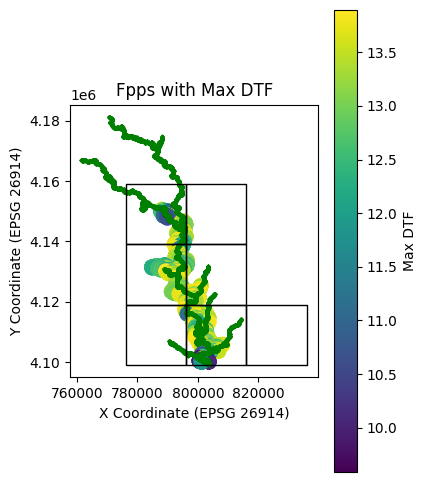

,FspId,FspX,FspY,SegId,FilledElev,DsDist,StrOrd,geometry
0,1,788175,4174775,32,254.768433,159780.274068,8,POINT (788175 4174775)
1,2,788165,4174765,32,254.768433,159766.131932,8,POINT (788165 4174765)
2,3,788155,4174755,32,254.768433,159751.989797,8,POINT (788155 4174755)
3,4,788145,4174745,32,254.768433,159737.847661,8,POINT (788145 4174745)
4,5,788135,4174735,32,254.768433,159723.705525,8,POINT (788135 4174735)
...,...,...,...,...,...,...,...,...
33770,33771,803755,4099275,197,205.321228,52.426407,1,POINT (803755 4099275)
33771,33772,803765,4099265,197,205.314590,38.284271,1,POINT (803765 4099265)
33772,33773,803775,4099255,197,205.307022,24.142136,1,POINT (803775 4099255)
33773,33774,803785,4099245,197,205.300446,10.000000,1,POINT (803785 4099245)


In [158]:
# PLOT FSP river profile and FPP at true edge pixel from RS

## Normalize the FspId_count for color mapping
# norm = Normalize(vmin=gdfRS_edges_filtered['NumsFSP'].min(), vmax=gdfRS_edges_filtered['NumsFSP'].max())
norm = Normalize(vmin=gdfRS_edges_filtered['max_depth'].min(), vmax=gdfRS_edges_filtered['max_depth'].max())
cmap = plt.cm.viridis

## Plot the data
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

# gdfRS_edges_filtered.plot(column='NumsFSP', cmap=cmap, markersize=100, ax=ax, legend=False, norm=norm)
gdfRS_edges_filtered.plot(column='max_depth', cmap=cmap, markersize=100, ax=ax, legend=False, norm=norm)

fsp_gdf[ (fsp_gdf.StrOrd == 1)|(fsp_gdf.StrOrd == 2) | (fsp_gdf.StrOrd == 3)|(fsp_gdf.StrOrd == 4) | (fsp_gdf.StrOrd == 5)|(fsp_gdf.StrOrd == 6) | (fsp_gdf.StrOrd == 7)| (fsp_gdf.StrOrd == 8)].plot(ax=ax, color='green', markersize=2, label='Fsp')

for i in unique_tile_ids:
    row = tile_index_df.loc[tile_index_df['TileId'] == i, ['TileMinX', 'TileMaxX', 'TileMinY', 'TileMaxY']]
    if not row.empty:
        minx,maxx,miny,maxy = row.iloc[0]

    rectangle = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])

    # Create a GeoDataFrame
    rec = gpd.GeoDataFrame([1], geometry=[rectangle], crs="EPSG:26914")
    rec.plot(ax=ax, edgecolor='black', markersize=1, facecolor='none')

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Max DTF')

ax.set_title('Fpps with Max DTF')
ax.set_xlabel('X Coordinate (EPSG 26914)')
ax.set_ylabel('Y Coordinate (EPSG 26914)')

plt.show()
gdfRS_edges_filtered
fsp_gdf

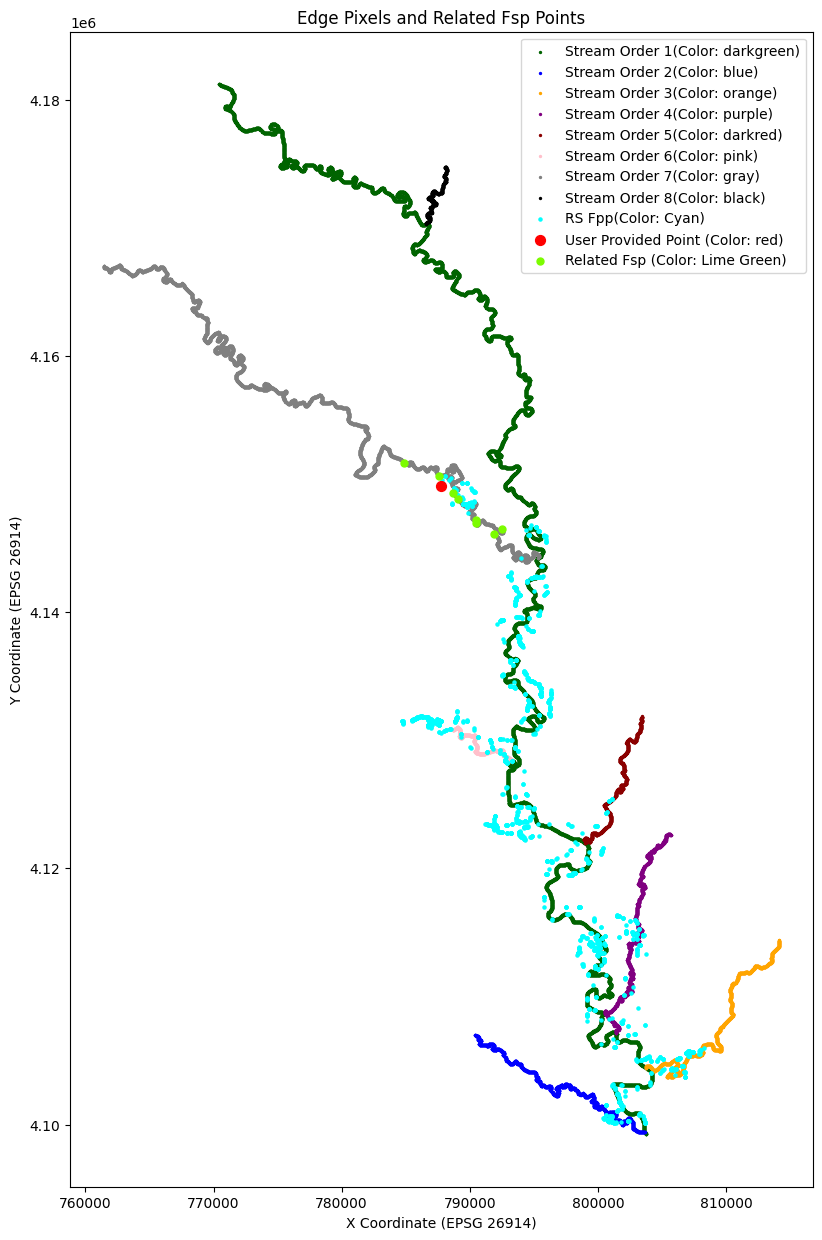

,FspId,FspX,FspY,SegId,FilledElev,DsDist,StrOrd,geometry
0,1,788175,4174775,32,254.768433,159780.274068,8,POINT (788175 4174775)
1,2,788165,4174765,32,254.768433,159766.131932,8,POINT (788165 4174765)
2,3,788155,4174755,32,254.768433,159751.989797,8,POINT (788155 4174755)
3,4,788145,4174745,32,254.768433,159737.847661,8,POINT (788145 4174745)
4,5,788135,4174735,32,254.768433,159723.705525,8,POINT (788135 4174735)
...,...,...,...,...,...,...,...,...
33770,33771,803755,4099275,197,205.321228,52.426407,1,POINT (803755 4099275)
33771,33772,803765,4099265,197,205.314590,38.284271,1,POINT (803765 4099265)
33772,33773,803775,4099255,197,205.307022,24.142136,1,POINT (803775 4099255)
33773,33774,803785,4099245,197,205.300446,10.000000,1,POINT (803785 4099245)


In [159]:
#Step 5.1 - Map a given Fpp and all Fsp related to it
## Function to plot the user-provided point and related Fsp points

def plot_user_point_and_fsps(user_point_index,gdf,fsp_gdf):
    user_point = gdf.iloc[user_point_index]
    related_fsp_ids = user_point['FspIds']
    related_fsps = fsp_gdf[fsp_gdf['FspId'].isin(related_fsp_ids)]
    
    stream_order_colors = {
        1: 'darkgreen',
        2: 'blue',
        3: 'orange',
        4: 'purple',
        5: 'darkred',
        6: 'pink',
        7: 'gray',
        8: 'black'
    }
    # Plot the data
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    for str_ord, color in stream_order_colors.items():
        # Filter Fsp points based on stream order and plot
        fsp_subset = fsp_gdf[fsp_gdf['StrOrd'] == str_ord]
        fsp_subset.plot(ax=ax, color=color, markersize=2, label=f'Stream Order {str_ord}(Color: {color})')
    # Plot the user-provided point
    gdf.plot(ax=ax, color='cyan', markersize=5, label='RS Fpp(Color: Cyan)')
    
    user_point_gdf = gpd.GeoDataFrame([user_point], geometry=[user_point.geometry])
    user_point_gdf.plot(ax=ax, color='red', markersize=50, label=f'User Provided Point (Color: red)')
    
    # Plot the related Fsp points
    related_fsps.plot(ax=ax, color='lawngreen', markersize=25, label='Related Fsp (Color: Lime Green)')
    
    # Set plot title and labels
    ax.set_title('Edge Pixels and Related Fsp Points')
    ax.set_xlabel('X Coordinate (EPSG 26914)')
    ax.set_ylabel('Y Coordinate (EPSG 26914)')
    
    plt.legend()
    plt.show()

plot_user_point_and_fsps(15,gdfRS_edges_filtered,fsp_gdf) #Change the number of the pixel here
fsp_gdf

# Step 6: Assign Dof to FSP from RS true edge 

In [160]:

def get_depth(fsp,dtf,dof):
    '''
    This function calculates the flood depth at a certain FPP given the Flood Source Pixel (FSP) that can flood 
    it, the Depth To Flood (DTF) relationship, and the Depth of Flood (DOF) or stage of the FSP. The flood depth
    is calculated as the maximum of (DOF - DTF) for each FSP. 
    
    If flood depth is less than 0 (no FSP can flood the FPP), return nan
    
    args:
        fsp (np.arary/list): FSP list
        dtf (np.arary/list): corresponding DTF of the FSP
        dof (np.array/list): corresponding DOF/stage of the FSP
        
    return:
        float: flood depth value
        nan: if FPP is not flooded
    '''
    fsp, dtf, dof = np.array(fsp), np.array(dtf), np.array(dof)
    depth = np.max(dof - dtf)
    
    if depth >= 0:
        return depth
    else:
        return np.nan


def filter_close_values(input_dict, threshold):
    '''
    This function reduces the number of options for each FSPs to reduce computational time. Given a certain threshold, 
    no two values within each list are closer than the threshold.
    
    args:
        input_dict (dict): Dictionary of key:value being FspID (int): Dof options (list)
        threshold (float): Threshold to remove values close to each other
    
    return:
        dict: filtered out FSP Dof functions 
    '''
    
    filtered_dict = {}
    for key, values in input_dict.items():
        # Sort values in descending order
        sorted_values = sorted(values, reverse=True)
        filtered_values = []
        for value in sorted_values:
            if all(abs(value - fv) > threshold for fv in filtered_values):
                filtered_values.append(value)
        
        filtered_dict[key] = filtered_values
    
    return filtered_dict


def num_of_combination(possible_fsp_dtf):
    '''
    This function calculate the number of possible combinations for FSP assignments 
    
    args:
        possible_fsp_dtf (dict): Dictionary of key:value being FspID (int): Dof options (list)
        
    return:
        int: number of combinations
    '''
    a = 1
    for key, value in possible_fsp_dtf.items():
        a = a*len(value)
    return a

## Note: In our study, we filtered out FPP at edges that have DTFs relationship higher than 10. Customize the threshold n in the cell below

In [161]:
# Add a threshold of NumofFSPs here for a subset of edges relationship
n = 10

# Run this instead to have no limitation of NumofFSP
gdfRS_edges_match_full = gdfRS_edges_filtered.copy()
n = gdfRS_edges_match_full.NumsFSP.max() 

gdfRS_edges_match = gdfRS_edges_match_full[gdfRS_edges_match_full.NumsFSP <= n].reset_index(drop = True) # Limit to edge with <= n Fsps
gdfRS_edges_match.Dtfs = gdfRS_edges_match.Dtfs.apply(lambda x:np.round(x,1)) # Round the dtfs by 1 decimal to reduce possible 
gdfRS_edges_match


,X_coord,Y_coord,TileId,FppCol,FppRow,FspIds,Dtfs,FilledDepth,NumsFSP,geometry,max_depth
0,788065.0,4150635.0,6.0,1199.0,845.0,"[18209, 18656, 18688, 19292, 19645, 19662, 199...","[12.0, 8.3, 8.5, 9.4, 11.2, 11.2, 13.0, 13.9]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",8,POINT (788065 4150635),13.865295
1,788065.0,4150605.0,6.0,1199.0,848.0,"[18209, 18656, 18688, 19292, 19645, 19662, 199...","[11.8, 8.3, 8.6, 9.3, 11.1, 11.1, 12.8, 13.7]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",8,POINT (788065 4150605),13.698883
2,788525.0,4150435.0,6.0,1245.0,865.0,"[19013, 19292, 19645, 19662, 19928, 20029]","[7.3, 8.0, 9.8, 9.8, 11.6, 12.4]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",6,POINT (788525 4150435),12.431717
3,788345.0,4150325.0,6.0,1227.0,876.0,"[18209, 18656, 19079, 19292, 19645, 19662, 199...","[11.7, 8.9, 7.3, 8.0, 9.8, 9.8, 11.6, 12.5]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",8,POINT (788345 4150325),12.473633
4,787855.0,4150295.0,6.0,1178.0,879.0,"[18209, 18656, 19072, 19292, 19645, 19662, 199...","[11.1, 8.3, 8.3, 8.6, 10.4, 10.4, 12.2, 13.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",8,POINT (787855 4150295),13.023468
...,...,...,...,...,...,...,...,...,...,...,...
1951,803645.0,4100125.0,9.0,757.0,1896.0,"[9688, 33693, 33761]","[10.0, 9.7, 10.1]","[0.0, 0.0, 0.0]",3,POINT (803645 4100125),10.069305
1952,801235.0,4100105.0,9.0,516.0,1898.0,"[8549, 9004, 9312, 33756, 33761]","[11.7, 6.3, 4.3, 10.0, 10.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",5,POINT (801235 4100105),11.672760
1953,801245.0,4100105.0,9.0,517.0,1898.0,"[8549, 9004, 9312, 33756, 33761]","[11.5, 6.3, 4.1, 9.8, 9.9]","[0.0, 0.0, 0.0, 0.0, 0.0]",5,POINT (801245 4100105),11.549438
1954,801425.0,4100105.0,9.0,535.0,1898.0,"[8549, 9004, 9394, 33756, 33761]","[11.0, 5.9, 3.5, 8.9, 9.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",5,POINT (801425 4100105),11.028473


### Note: There are two ways to assign Dof of FSP. One way is to use the median of all possible DTFs options for each FSP based on their relationships to FPP flood edge. Another way is to going through all possible combination of FSP Dof assignment and find the combination that provides the lowest flood depth across all flood edge pixels. 
## Step 6.1 Median of choices

In [162]:
# # # Create the dictionary of all possible FSP that can be assigned from true edge and the corresponding DTF to each of them.

possible_fsp_dtf = defaultdict(set)

for fspids, dtfs in zip(gdfRS_edges_match['FspIds'], gdfRS_edges_match['Dtfs']): 
    for fspid, dtf in zip(fspids, dtfs):
        possible_fsp_dtf[fspid].add(dtf)

# Convert sets to lists
possible_fsp_dtf = {k: list(v) for k, v in possible_fsp_dtf.items()}
print('Total number of possible Fsps are %s'%(len(possible_fsp_dtf)))
# FOR EACH FSP, TAKE THE MEDIAN OF ALL CHOICES AS OPTIMAL
best_case = {}

for key, value in possible_fsp_dtf.items():
    best_case[key] = np.median(value) 
# Evaluate the depths at all flood edges
total_edge_depth = []
    
for j in range( gdfRS_edges_match.shape[0]): # Iterate through all true edges to get the depth for certain combination
    
    fsp = gdfRS_edges_match.loc[j, 'FspIds']
    dtf = gdfRS_edges_match.loc[j, 'Dtfs']  
    dof = [best_case[key] for key in fsp]

    flood_depth = get_depth(fsp,dtf,dof)
    total_edge_depth.append(flood_depth)


print('Total edge pixels: %s'%(gdfRS_edges_match.shape[0]))
print('Edge pixels that dont get flooded: %s'%(np.count_nonzero(np.isnan(total_edge_depth))))
print('Median flood depth at edge pixel: %s'%(np.nanmedian(total_edge_depth).round(2)))
print('Mean flood depth at edge pixel: %s'%(np.nanmean(total_edge_depth).round(2)))
print('Max flood depth at edge pixel: %s'%(np.nanmax(total_edge_depth).round(2)))

Total number of possible Fsps are 375
Total edge pixels: 1956
Edge pixels that dont get flooded: 230
Median flood depth at edge pixel: 0.9
Mean flood depth at edge pixel: 1.42
Max flood depth at edge pixel: 10.1


## Step 6.2: Go through all possible combinations
### Note: We use the set of true edges with the lowest NumofFSP to assign associated FSP Dofs and then iteratively move on to the set of true edge with higher NumofFSP. Fsps being assigned in each iteration doesn't change after each iteration. 

### Set the maximum number of possible combinations for each iteration. When the total number of possible combinations exceed this value, the FSP DOF dictionary is filtered with a 0.1 incremental threshold to remove Dofs options that are close to each other

In [163]:
# max_combinations = 100000
# best_case = {}

# for i in range(gdfRS_edges_match_full.NumsFSP.min(),n + 1): 
#     print("NumofFSPs <= %s"%(i))
#     gdfRS_edges_match = gdfRS_edges_match_full[gdfRS_edges_match_full.NumsFSP <= i].reset_index(drop = True) # Limit to edge with <= n Fsps
#     gdfRS_edges_match.Dtfs = gdfRS_edges_match.Dtfs.apply(lambda x:np.round(x,1)) # Round the dtfs by 1 decimal to reduce possible 

#     possible_fsp_dtf = defaultdict(set)

#     for fspids, dtfs in zip(gdfRS_edges_match['FspIds'], gdfRS_edges_match['Dtfs']): 
#         for fspid, dtf in zip(fspids, dtfs):
#             possible_fsp_dtf[fspid].add(dtf)
    
#     # Convert sets to lists
#     possible_fsp_dtf = {k: list(v) for k, v in possible_fsp_dtf.items()}
#     print('Total number of possible Fsp are %s'%(len(possible_fsp_dtf)))

#     # Replace FSP choices dictionary with FSP that is already optimized in previous iteration
#     for key,value in best_case.items():
#         possible_fsp_dtf[key] = [value]


#     # Get original number of combinations
#     num_choice = num_of_combination(possible_fsp_dtf)
#     print('There are %s options of FSP DOF '%(num_choice))

#     # If there are too many options
#     threshold = 0.1
#     while num_choice > max_combinations:
#         possible_fsp_dtf = filter_close_values(possible_fsp_dtf, threshold)
#         num_choice = num_of_combination(possible_fsp_dtf)
#         print('Applied %s threshold. There are %s options of FSP DOF '%(np.round(threshold, 1), num_choice))
#         threshold += 0.1

#     # Generation all combinations
#     fsp = list(possible_fsp_dtf.keys())
#     dtf_options = list(possible_fsp_dtf.values())
#     combinations = [dict(zip(fsp, combo)) for combo in product(*dtf_options)]


#     total_edge_depth_optimize = [np.inf]
#     idx_optimize = np.nan
    
#     # Find the best combination that minimize flood depth at edge
#     for i in range(len(combinations)): # Iterate through each combinations of FSPs' DOF
#         total_edge_depth = []
#         edge_condition = True
        
#         for j in range( gdfRS_edges_match.shape[0]): # Iterate through all true edges to get the depth for certain combination
            
#             fsp = gdfRS_edges_match.loc[j, 'FspIds']
#             dtf = gdfRS_edges_match.loc[j, 'Dtfs']  
#             dof = [combinations[i][key] for key in fsp]
        
#             flood_depth = get_depth(fsp,dtf,dof)
#             if np.isnan(flood_depth): # Stop calculating when the scenario produces a true edge that is not flooded
#                 edge_condition = False
#                 break
#             else:
#                 total_edge_depth.append(flood_depth)
                
#         if not edge_condition: # Go to the next combination
#             continue
#         else:
#             if sum(total_edge_depth) < sum(total_edge_depth_optimize):
#                 total_edge_depth_optimize = total_edge_depth
#                 idx_optimize = i
                
#     best_case = combinations[idx_optimize]
#     print('%s FSP optimized' %(len(best_case)))
#     print()
#     print('Total edge pixels: %s'%(gdfRS_edges_match.shape[0]))
#     print('Edge pixels that dont get flooded: %s'%(np.count_nonzero(np.isnan(total_edge_depth_optimize))))
#     print('Median flood depth at edge pixels: %s'%(np.nanmedian(total_edge_depth_optimize).round(2)))
#     print('Mean flood depth at edge pixels: %s'%(np.nanmean(total_edge_depth_optimize).round(2)))
#     print('Max flood depth at edge pixels: %s'%(np.nanmax(total_edge_depth_optimize).round(2)))
#     print()
#     print('-------------------------------------------------------------------------------------------')
#     print()

# Step 7: SNAP to FSP

In [164]:
# Create the FSP Geodataframe with Dof being the optimized Dof derived from either way above
sol = fsp_gdf.set_index('FspId').loc[best_case.keys()]
sol['Dof'] = sol.index.map(best_case)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(sol)

print(sol['StrOrd'].value_counts())

highest_value = sol['StrOrd'].value_counts().index[0]
print(highest_value)

,FspX,FspY,SegId,FilledElev,DsDist,StrOrd,geometry,Dof
FspId,,,,,,,,
18209,784885,4151675,150,243.412720,124391.599488,7,POINT (784885 4151675),11.70
18656,788165,4150785,151,241.449249,119093.172363,7,POINT (788165 4150785),9.00
18688,788215,4151105,152,241.332718,118752.461685,7,POINT (788215 4151105),8.55
19292,789095,4148865,153,239.348389,111552.663710,7,POINT (789095 4148865),7.55
19645,790475,4147155,154,237.538818,107227.373670,7,POINT (790475 4147155),9.05
19662,790505,4146985,155,237.538818,107036.662992,7,POINT (790505 4146985),9.00
19928,792545,4146465,156,235.769409,104012.155057,7,POINT (792545 4146465),10.75
20029,791905,4146115,157,234.910919,102811.616819,7,POINT (791905 4146115),11.65
19013,788575,4150415,152,240.061157,114848.004256,7,POINT (788575 4150415),7.30


StrOrd
1    224
7     52
4     31
3     25
2     18
6     14
5     11
Name: count, dtype: int64
1


### Note: In our study, we only kept assign FSPs on the mainstem. Skip this cell below if needed

In [165]:
# max_distance = 100000  # Set a cap for max distance from the source for higher stream orders
# fspSnapped = fspSnapped[(fspSnapped['StrOrd'] == 1) | ((fspSnapped['StrOrd'] > 1) & (fspSnapped['DsDist'] <= max_distance))]

sol = sol[(sol['StrOrd'] == highest_value)]

#If instead you want to select a certain stream order you can use 
#sol = sol[sol['StrOrd'] == Any Stream Order Number)]

display(sol)
gaugeFspDf = sol[['FspX', 'FspY', 'StrOrd', 'DsDist', 'SegId', 'FilledElev','Dof']].reset_index(drop = True)
gaugeFspDf.insert(0, 'lib_name', 'lib_fldsensing',)
print(gaugeFspDf)


,FspX,FspY,SegId,FilledElev,DsDist,StrOrd,geometry,Dof
FspId,,,,,,,,
25730,795345,4144215,169,230.497467,93510.153622,1,POINT (795345 4144215),11.70
25731,795335,4144215,170,230.497467,93500.153622,1,POINT (795335 4144215),10.35
25893,795505,4143275,171,229.671478,91652.336162,1,POINT (795505 4143275),11.00
26127,795065,4141505,172,229.161850,88885.696193,1,POINT (795065 4141505),9.70
26395,794365,4140205,173,228.288956,85808.051173,1,POINT (794365 4140205),10.55
...,...,...,...,...,...,...,...,...
33611,803275,4100865,196,206.209808,1847.106781,1,POINT (803275 4100865),1.60
33612,803275,4100855,196,206.209808,1837.106781,1,POINT (803275 4100855),9.60
33617,803295,4100805,196,206.108582,1778.822510,1,POINT (803295 4100805),9.40


           lib_name    FspX     FspY  StrOrd        DsDist  SegId  FilledElev  \
0    lib_fldsensing  795345  4144215       1  93510.153622    169  230.497467   
1    lib_fldsensing  795335  4144215       1  93500.153622    170  230.497467   
2    lib_fldsensing  795505  4143275       1  91652.336162    171  229.671478   
3    lib_fldsensing  795065  4141505       1  88885.696193    172  229.161850   
4    lib_fldsensing  794365  4140205       1  85808.051173    173  228.288956   
..              ...     ...      ...     ...           ...    ...         ...   
219  lib_fldsensing  803275  4100865       1   1847.106781    196  206.209808   
220  lib_fldsensing  803275  4100855       1   1837.106781    196  206.209808   
221  lib_fldsensing  803295  4100805       1   1778.822510    196  206.108582   
222  lib_fldsensing  803475  4100465       1   1358.406204    196  205.917542   
223  lib_fldsensing  803595  4100055       1    898.700577    196  205.711746   

       Dof  
0    11.70  
1

# Step 8: Interpolate FSP's DOF

Here we interpolate the DOF for all the FSPs between the gauge-FSPs using their DOF calculated from previous step. The interpolation uses stream orders and starts from low stream order (i.e., main streams) to high stream order (i.e., tributatried). Either horizontal or vertical (by defaut) interpolation can be used.

In [166]:
# Find libs with snapped gauges. They are the actual libs to map
libs2Map = gaugeFspDf['lib_name'].drop_duplicates().tolist()
print(libs2Map)

# prepare the DF for storing interpolated FSP DOF
fspDof = pd.DataFrame(columns=['LibName','FspId','Dof'])

# prepare DFs for saving interpolated FSPs and their segment IDs
fspCols = fspInfoColumnNames + ['Dof']
segIdCols = ['SegId','LibName']
fsps = pd.DataFrame(columns=fspCols)
segIds =pd.DataFrame(columns=segIdCols)

# map each library
for libName in libs2Map:
    # interpolate DOF for the gauges
    # print('Interpolate FSP DOF using gauge DOF ...')
    # fspIdDof = InterpolateFspDofFromGauge(libFolder,libName,gaugeFspDf) # 'V' by default
    fspIdDof = InterpolateFspDofFromGauge(libFolder,libName,gaugeFspDf,weightingType='H') # horizontal interpolation
    fspIdDof['LibName'] = libName
    # fspDof = fspDof.append(fspIdDof[['LibName','FspId','Dof']], ignore_index=True)
    fspDof = pd.concat([fspDof,fspIdDof[['LibName','FspId','Dof']]], ignore_index=True)

    # Keep interpolated FSP DOF for saving later
    fspFile = os.path.join(libFolder, libName, fspInfoFileName)
    fspDf = pd.read_csv(fspFile) 
    fspDf = pd.merge(fspDf,fspDof,how='inner',on=['FspId'])
    # fsps = fsps.append(fspDf, ignore_index=True)
    fsps = pd.concat([fsps,fspDf], ignore_index=True)
    
    # Keep FSP segment IDs for saving later
    t =  pd.DataFrame(fspDf['SegId'].drop_duplicates().sort_values())
    t['LibName'] = libName
    # segIds = segIds.append(t, ignore_index=True)
    segIds = pd.concat([segIds,t], ignore_index=True)

# show interpolated FSPs with Dof
print(fspDof)

#
# save interpolated FSP DOF and their segments for checking. This block of code should be commented out if no-checking needed
#
# Save DOF and segment IDs to CSV files
FspDofFile = os.path.join(outputFolder, 'Interpolated_FSP_DOF.csv')
SegIdFile = os.path.join(outputFolder, 'Interpolated_SegIds.csv')

fsps.to_csv(FspDofFile, index=False)
segIds.to_csv(SegIdFile, index=False)

['lib_fldsensing']
             LibName  FspId       Dof
0     lib_fldsensing  24262  6.764224
1     lib_fldsensing  24263  6.767782
2     lib_fldsensing  24264  6.771340
3     lib_fldsensing  24265  6.774898
4     lib_fldsensing  24266  6.778455
...              ...    ...       ...
9509  lib_fldsensing  33771  2.791202
9510  lib_fldsensing  33772  2.038269
9511  lib_fldsensing  33773  1.285337
9512  lib_fldsensing  33774  0.532404
9513  lib_fldsensing  33775  0.000000

[9514 rows x 3 columns]


# Step 9: Map Flood Inundation Depth
### Set Mapping Parameters

Setup the map folder (i.e., outMapFolderName) which is under the output folder and comtains all inundation depth maps. Additional settings include whether to mosaic tiles as single COG file and whether use a Dask local cluster to speed up the mapping.

In [167]:
# whether mosaci tiles as a single COG
mosaicTiles = True #True #False

# Using LocalCluster by default
useLocalCluster = False # This doesn't work on my office desktop though it works fine on KBS server
numOfWorkers = round(0.8*os.cpu_count())
numOfWorkers = 6
print(f'Number of workers: {numOfWorkers}')

Number of workers: 6


### Map Inundation Depth

The process of generating inundation depth map happens here.

In [168]:
# show mapping info
print(f'Tiled FLDPLN library folder: {libFolder}')
print(f'Map folder: {outMapFolder}')
# Find libs needs mapping
libs2Map = fspDof['LibName'].drop_duplicates().tolist()
print(f'Libraries to map: {libs2Map}')

# check running time
startTimeAllLibs = time.time()

# create a local cluster to speed up the mapping. Must be run inside "if __name__ == '__main__'"!!!
if useLocalCluster:
    # cluster = LocalCluster(n_workers=4,processes=False)
    try:
        print('Start a LocalCluster ...')
        # NOTE: set worker space (i.e., local_dir) to a folder that the LocalCluster can access. When run the script through a scheduled task, 
        # the system uses C:\Windows\system32 by default, which a typical user doesn't have the access!
        # cluster = LocalCluster(n_workers=numOfWorkers,memory_limit='32GB',local_dir="D:/projects_new/fldpln/tools") # for KARS production server (192G RAM & 8 cores)
        # cluster = LocalCluster(n_workers=numOfWorkers,processes=False) # for KARS production server (192G RAM & 8 cores)
        cluster = LocalCluster(n_workers=numOfWorkers,memory_limit='8GB',local_dir="D:\temp") # for office desktop (64G RAM & 8 cores)
        # print('Watch workers at: ',cluster.dashboard_link)
        print(f'Number of workers: {numOfWorkers}')
        client = Client(cluster)
        # print scheduler info
        # print(client.scheduler_info())
    except:
        print('Cannot create a LocalCLuster!')
        useLocalCluster = False

# dict to store lib processing time
libTime={}

# map each library
for libName in libs2Map:
    # check running time
    startTime = time.time()
    
    print(fspDof)
    # select the FSPs within the lib
    fspIdDof = fspDof[fspDof['LibName']==libName][['FspId','Dof']]
    print(fspIdDof)

    # mapping flood depth
    if useLocalCluster:
        print(f'Map [{libName}] using LocalCLuster ...')
        # generate a DAG
        dag,dagRoot=MapFloodDepthWithTilesAsDag(libFolder,libName,'snappy',outMapFolder,fspIdDof,aoiExtent=None)
        if dag is None:
            tileTifs = None
        else:
            # visualize DAG
            # visualize(dag)
            # Compute DAG
            tileTifs = client.get(dag, dagRoot)
            if not tileTifs: # list is empty
                tileTifs =  None
    else:
        print(f'Map {libName} ...')
        tileTifs = MapFloodDepthWithTiles(libFolder,libName,'snappy',outMapFolder,fspIdDof,aoiExtent=None)
    print(f'Actual mapped tiles: {tileTifs}')

    # Mosaic all the tiles from a library into one tif file
    if mosaicTiles and not(tileTifs is None):
        print('Mosaic tile maps ...')
        mosaicTifName = libName+'_'+outMapFolderName+'.tif'
        # Simplest implementation, may crash with very large raster
        MosaicGtifs(outMapFolder,tileTifs,mosaicTifName,keepTifs=False)
    
    # check time
    endTime = time.time()
    usedTime = round((endTime-startTime)/60,3)
    libTime[libName] = usedTime
    # print(f'{libName} processing time (minutes):', usedTime)

# Show processing time
# Individual lib processing time
print('Individual library mapping time:', libTime)
# total time
endTimeAllLibs = time.time()
print('Total processing time (minutes):', round((endTimeAllLibs-startTimeAllLibs)/60,3))

#
# Shutdown local clusters
#
if useLocalCluster:
    print('Shutdown LocalCluster ...')
    cluster.close()
    client.shutdown()
    client.close()
    useLocalCluster = False

Tiled FLDPLN library folder: C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/tiled_snz_library
Map folder: C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/maps\Testing12
Libraries to map: ['lib_fldsensing']
             LibName  FspId       Dof
0     lib_fldsensing  24262  6.764224
1     lib_fldsensing  24263  6.767782
2     lib_fldsensing  24264  6.771340
3     lib_fldsensing  24265  6.774898
4     lib_fldsensing  24266  6.778455
...              ...    ...       ...
9509  lib_fldsensing  33771  2.791202
9510  lib_fldsensing  33772  2.038269
9511  lib_fldsensing  33773  1.285337
9512  lib_fldsensing  33774  0.532404
9513  lib_fldsensing  33775  0.000000

[9514 rows x 3 columns]
      FspId       Dof
0     24262  6.764224
1     24263  6.767782
2     24264  6.771340
3     24265  6.774898
4     24266  6.778455
...     ...       ...
9509  33771  2.791202
9510  33772  2.038269
9511  33773  1.285337
9512  33774  0.532404
9513  33775  0.000000

[9514 rows x 2 column

<Axes: >

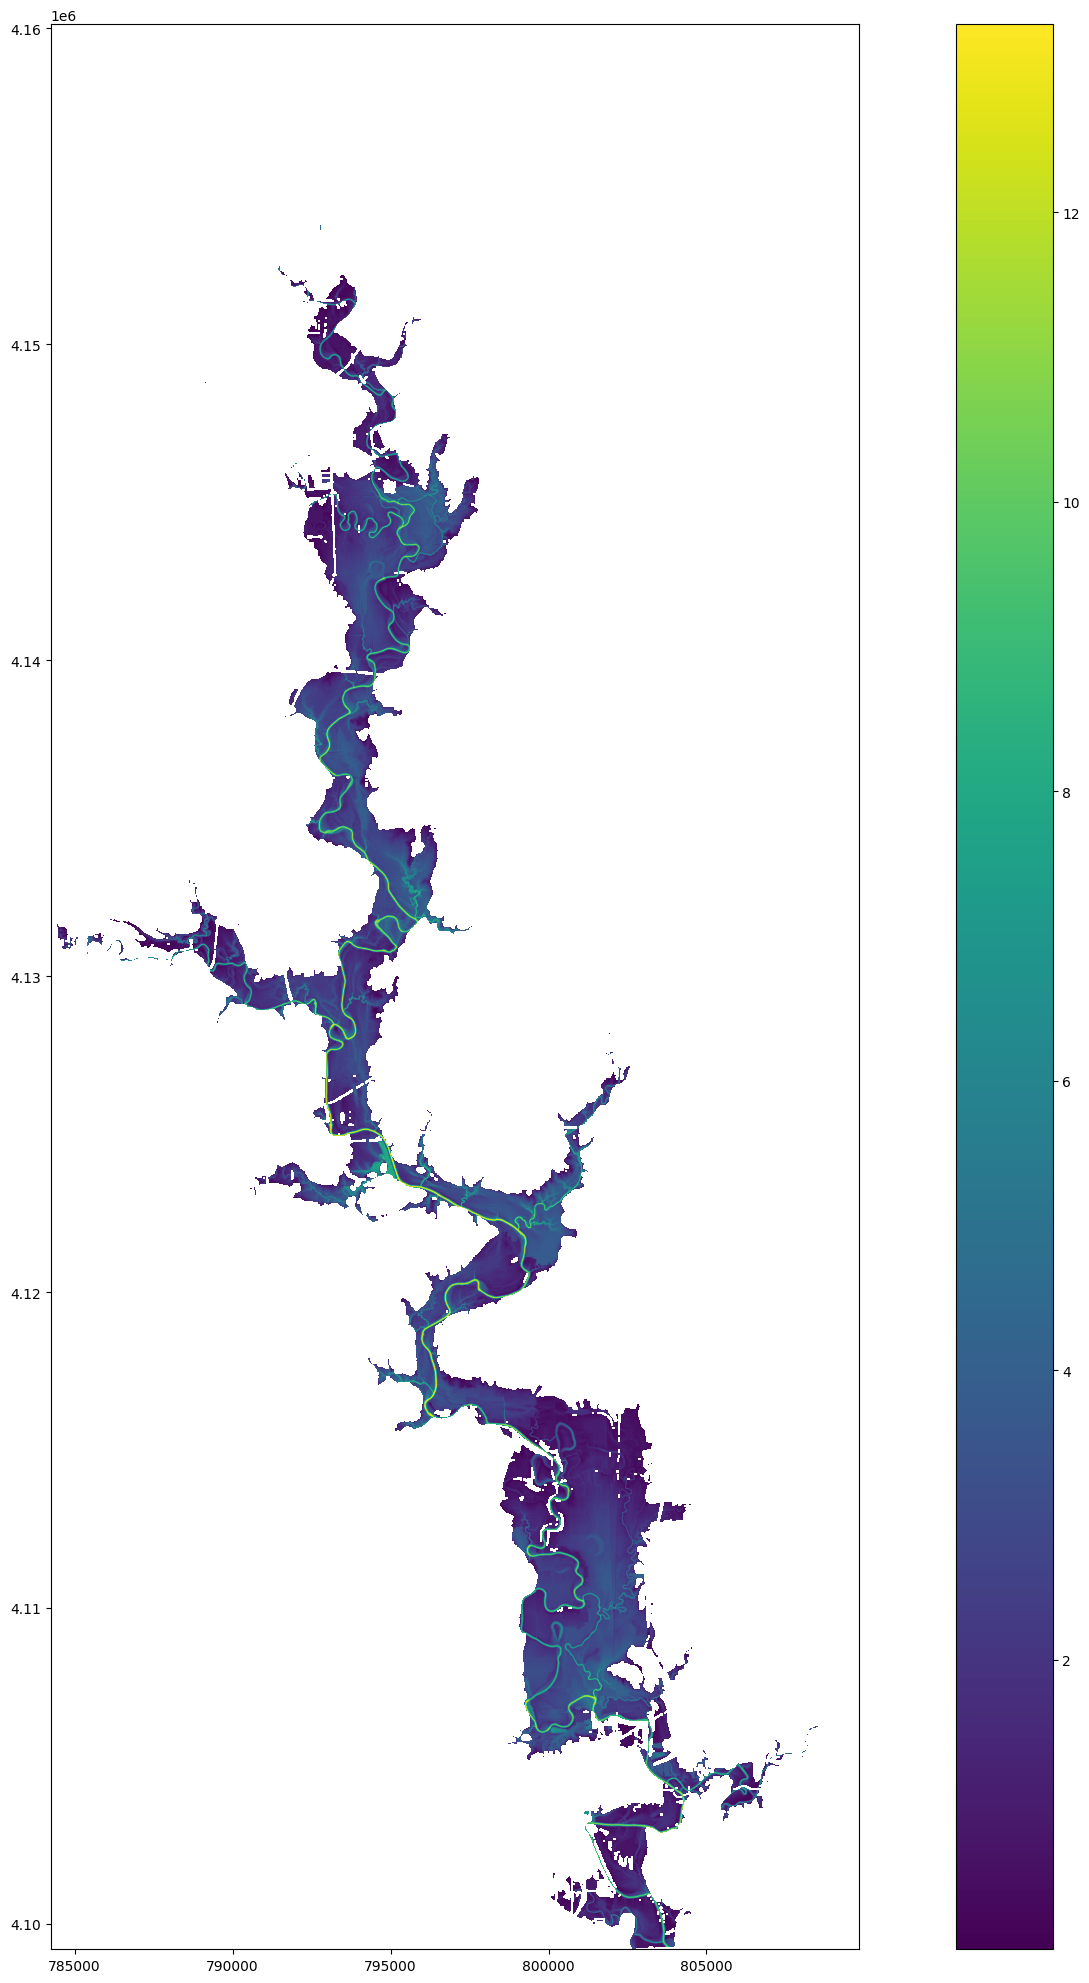

In [169]:
fp = r"C:\Users\hobbe\Documents\Thesis\fldpln\Data\verdigris_10m_v8\maps\Testing9\lib_fldsensing_Testing9.tif"

raster = rasterio.open(fp)
fig, ax = plt.subplots(figsize=(25,25))
#image_hidden = ax.imshow(raster.read(1))
image_hidden = ax.imshow(raster.read(1, masked=True))

fig.colorbar(image_hidden, ax=ax)
rasterio.plot.show(raster, ax=ax)


### Turning the water surface elevator from the above FSPInfo folder into a raster

To display water surface elevation changes when changing various parameters

In [170]:

# Load the CSV file
file_path = "C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/maps/Interpolated_FSP_DOF.csv"
fsp_data = pd.read_csv(file_path)

# Ensure StrOrd is numeric
fsp_data['StrOrd'] = pd.to_numeric(fsp_data['StrOrd'], errors='coerce')


# Calculate Water Surface Elevation (WSE) as FilledElev + Dof
fsp_data['WSE'] = fsp_data['FilledElev'] + fsp_data['Dof']
fsp_data['DsDist']=fsp_data['DsDist']
#print(fsp_data)

# Create a GeoDataFrame from the FSP coordinates
geometry = [Point(xy) for xy in zip(fsp_data['FspX'], fsp_data['FspY'])]
fsp_gdf = gpd.GeoDataFrame(fsp_data, geometry=geometry)

# Set the CRS to EPSG:26914 (UTM Zone 14N)
fsp_gdf.set_crs(epsg=26914, inplace=True)

# Create an empty raster with the desired resolution (e.g., 10 meters)
x_min, y_min, x_max, y_max = fsp_gdf.total_bounds
resolution = 10  # Example resolution (10 meters)
cols = int((x_max - x_min) / resolution) + 1  # +1 to include the edge
rows = int((y_max - y_min) / resolution) + 1  # +1 to include the edge
fspid_data = np.full((rows, cols), np.nan)

# Create an empty array for the raster data
raster_data = np.full((rows, cols), np.nan)
#print(fsp_gdf)

# Get the transform for the raster (defines the geo-referencing)
transform = from_origin(x_min, y_max, resolution, resolution)

# Fill in the raster array with WSE values at the FSP coordinates
for idx, row in fsp_gdf.iterrows():
    col = int((row.geometry.x - x_min) / resolution)
    row_idx = int((y_max - row.geometry.y) / resolution)
    
    # Ensure indices are within bounds
    if 0 <= row_idx < rows and 0 <= col < cols:
        raster_data[row_idx, col] = row['WSE']
        #fspid_data[row_idx, col] = row['FspId'] 
    else:
        print(f"Index out of bounds for coordinates: {row.geometry.x}, {row.geometry.y}")

# Define the raster's metadata
raster_meta = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'nodata': np.nan,
    'width': cols,
    'height': rows,
    'count': 1,
    'crs': fsp_gdf.crs,
    'transform': transform
}

# Save the raster as a GeoTIFF
output_tiff_path = 'WSE_rasterWithTributaries.tif'
with rasterio.open(output_tiff_path, 'w', **raster_meta) as dst:
    dst.write(raster_data.astype(np.float32), 1)

print(f"Raster saved as {output_tiff_path}")

fig, ax = plt.subplots(figsize=(10, 8))

tributaries = fsp_gdf[fsp_gdf['StrOrd'] > 1]
mainstem = fsp_gdf[fsp_gdf['StrOrd'] == 1]

print(fsp_gdf)
fsp_gdf.to_csv('WSEWithTrib.csv')

# Plot the mainstem and tributaries
mainstem.plot(ax=ax, marker='o', color='blue', markersize=5)
tributaries.plot(ax=ax, marker='x', color='red', markersize=5)

# Add a colorbar for the water surface elevation (WSE) based on 'FilledElev'
mainstem.plot(column='WSE', cmap='Reds', ax=ax, legend=True)

# Add titles and labels
ax.set_title('Mainstem FSP Water Surface Elevation with Tributaries')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

plt.legend()
plt.show()

CPLE_AppDefinedError: Deleting WSE_rasterWithTributaries.tif failed: Permission denied

0       102523.626920
1       102509.484784
2       102499.484784
3       102489.484784
4       102475.342649
            ...      
8804        52.426407
8805        38.284271
8806        24.142136
8807        10.000000
8808         0.000000
Name: DsDist, Length: 8809, dtype: float64
0       240.693173
1       240.695008
2       240.696306
3       240.697603
4       240.699438
           ...    
8804    208.140066
8805    207.373041
8806    206.605085
8807    205.838121
8808    205.299057
Name: WSE, Length: 8809, dtype: float64


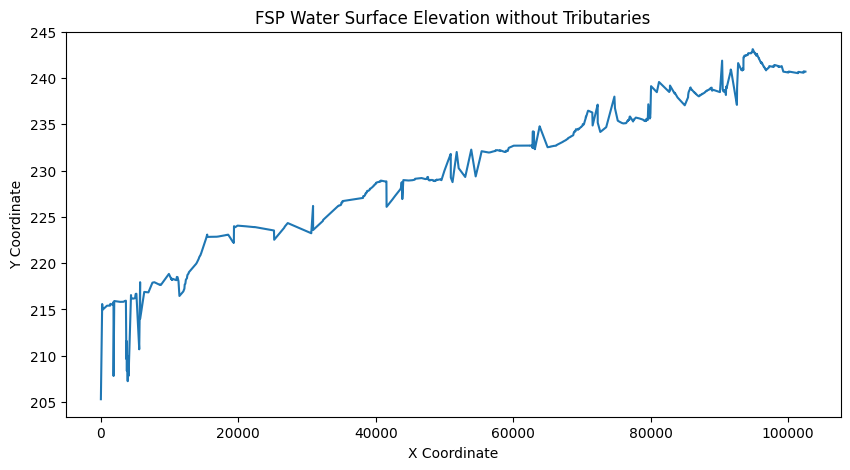

In [147]:
dstData = fsp_gdf.query('StrOrd ==1')['DsDist']
print(dstData)
wseData = fsp_gdf.query('StrOrd ==1')['WSE']
print(wseData)
filledElevData = fsp_gdf.query('StrOrd ==1')['FilledElev']
f = plt.figure()
plt.title('FSP Water Surface Elevation without Tributaries')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(dstData,wseData)
